/var/folders/fd/ydg6rp911tsg6lqqdq4ngjrssqsnwv/T/ipykernel_16909/2146052079.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1])


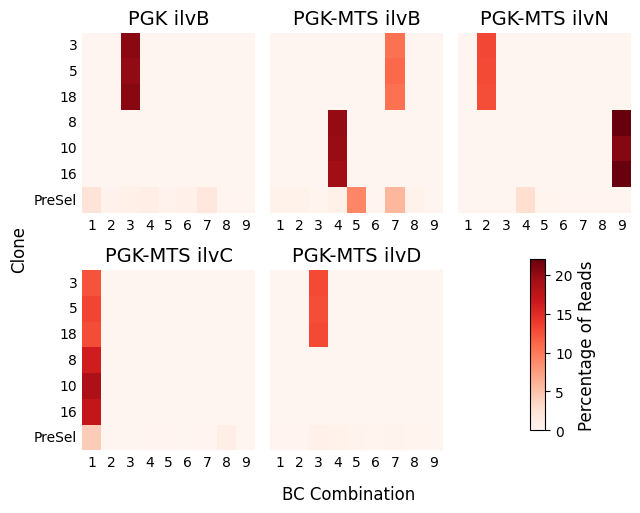

In [13]:
#diversity underlying best solution
#only strong prototrophic clones included

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------- Sample relabeling ----------
sample_label_map = {
    "Counts_BS28195A": "PreSel",
    "Counts_BS27978A": "3",
    "Counts_BS27990A": "5",
    "Counts_BS27993A": "18",
    "Counts_BS27983A": "8",
    "Counts_BS27985A": "10",
    "Counts_BS27991A": "16",
}

subplot_title_map = {
    "ilvB__PGK": "PGK ilvB",
    "ilvB__PGK-MTS": "PGK-MTS ilvB",
    "ilvN__PGK-MTS": "PGK-MTS ilvN",
    "ilvC__PGK-MTS": "PGK-MTS ilvC",
    "ilvD__PGK-MTS": "PGK-MTS ilvD",
}

# ---------- Load data ----------
def load_data(file_paths):
    all_data = []
    for file_path in file_paths:
        sample_name = os.path.basename(file_path).split('.')[0]
        try:
            df = pd.read_csv(
                file_path,
                sep=",",
                header=None,
                names=["Barcode_Pair", "Gene_Promoter", "Barcode", "Count"],
                dtype=str,
                skiprows=10,
                encoding='utf-8'
            )
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
            continue

        if df.shape[1] != 4:
            print(f"Unexpected columns in {file_path}: {df.columns}")
            continue

        df = df[df["Barcode_Pair"].str.contains("__")]
        df["Count"] = pd.to_numeric(df["Count"], errors="coerce")
        df["Sample"] = sample_label_map.get(sample_name, sample_name)

        total = df["Count"].sum()
        if total > 0:
            df["Count"] = df["Count"] / total * 100

        all_data.append(df)

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

# ---------- Plot barcode usage heatmap ----------
def plot_multiple_barcode_heatmaps(df, gene_promoter_pairs, cmap="Reds"):
    pivot_dfs = []
    all_values = []

    desired_order = ["3", "5", "18", "8", "10", "16", "PreSel"]

    for gp in gene_promoter_pairs:
        sub_df = df[df["Gene_Promoter"] == gp].copy()
        sub_df[["Gene_Barcode", "Promoter_Barcode"]] = sub_df["Barcode_Pair"].str.split("__", expand=True)
        top_gene_bcs = sub_df.groupby("Gene_Barcode")["Count"].sum().nlargest(3).index.tolist()
        top_prom_bcs = sub_df.groupby("Promoter_Barcode")["Count"].sum().nlargest(3).index.tolist()
        expected_barcode_pairs = [f"{g}__{p}" for g in top_gene_bcs for p in top_prom_bcs]
        sub_df["Barcode_Pair"] = sub_df["Gene_Barcode"] + "__" + sub_df["Promoter_Barcode"]
        sub_df = sub_df[sub_df["Barcode_Pair"].isin(expected_barcode_pairs)]

        pivot_df = sub_df.pivot_table(
            index="Sample",
            columns="Barcode_Pair",
            values="Count",
            aggfunc="sum",
            fill_value=0
        )
        for bc in expected_barcode_pairs:
            if bc not in pivot_df.columns:
                pivot_df[bc] = 0

        pivot_df = pivot_df.reindex(desired_order)
        pivot_df = pivot_df[sorted(pivot_df.columns)]
        pivot_dfs.append((gp, pivot_df))
        all_values.append(pivot_df.values)

    global_data = np.concatenate(all_values, axis=None)
    vmin, vmax = global_data.min(), global_data.max()

    num_plots = len(pivot_dfs)
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, len(pivot_dfs[0][1].index) * 0.35 * rows), squeeze=False)

    for idx, (gp, pivot_df) in enumerate(pivot_dfs):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        sns.heatmap(
            pivot_df,
            ax=ax,
            cmap=cmap,
            cbar=False,
            vmin=vmin,
            vmax=vmax
        )

        if col == 0:
            ax.set_yticks(np.arange(len(pivot_df.index)) + 0.5)
            ax.set_yticklabels(pivot_df.index.tolist(), rotation=0)
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        num_cols = pivot_df.shape[1]
        ax.set_xticks(np.arange(num_cols) + 0.5)
        ax.set_xticklabels([str(i + 1) for i in range(num_cols)], rotation=0)

        ax.tick_params(axis='both', length=0)
        ax.set_title(subplot_title_map.get(gp, gp), fontsize=14)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Remove unused subplot (bottom right)
    fig.delaxes(axes[1, 2])

    # Place colorbar in that slot
    bbox = axes[1, 2].get_position()
    cbar_width = bbox.width * 0.1
    cbar_left = bbox.x0 + (bbox.width - cbar_width) / 2
    cbar_ax = fig.add_axes([cbar_left, bbox.y0, cbar_width, bbox.height])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label("Percentage of Reads", fontsize=12)

    fig.text(0.5, -0.02, "BC Combination", ha='center', va='center', fontsize=12)
    fig.text(0.0, 0.48, "Clone", ha='center', va='center', rotation='vertical', fontsize=12)

    fig.tight_layout(rect=[0, 0, 0.95, 1])
    fig.savefig("/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Jurkat_Val_Consensus_BCDiv.svg", format="svg", bbox_inches="tight")
    plt.show()

file_paths = [
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Counts/output_csvs/Counts_BS28195A', #Jurkat Pre-sel
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27978A',
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27990A',
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27993A',
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27983A',
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27985A',
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27991A',
]

# ---------- Run ----------

data = load_data(file_paths)

plot_multiple_barcode_heatmaps(
    data,
    gene_promoter_pairs=["ilvB__PGK", "ilvB__PGK-MTS", "ilvN__PGK-MTS", "ilvC__PGK-MTS", "ilvD__PGK-MTS"]
)